In [68]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report, accuracy_score, recall_score

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [69]:
df = pd.read_csv("BankChurners.csv")
df = df.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2','CLIENTNUM'],axis='columns')
df["Attrition_Flag"] = df["Attrition_Flag"].map({"Existing Customer":0, "Attrited Customer":1})
le = LabelEncoder()
df['Education_Level']= le.fit_transform(df['Education_Level'])
df['Gender']= le.fit_transform(df['Gender'])
df['Card_Category']= le.fit_transform(df['Card_Category'])
df['Income_Category']= le.fit_transform(df['Income_Category'])
df['Marital_Status']= le.fit_transform(df['Marital_Status'])
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,1,3,3,1,2,0,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,0,5,2,2,4,0,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,1,3,2,1,3,0,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,0,4,3,3,4,0,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,1,3,5,1,2,0,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [70]:
k=df.groupby('Attrition_Flag').mean()
print(df[['Attrition_Flag','Gender']].groupby('Attrition_Flag').count())
k

                Gender
Attrition_Flag        
0                 8500
1                 1627


,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
Attrition_Flag,,,,,,,,,,,,,,,,,,,
0,46.262118,0.479059,2.335412,3.092118,1.457412,2.852353,0.181647,35.880588,3.914588,2.273765,2.356353,8726.877518,1256.604118,7470.273400,0.772510,4654.655882,68.672588,0.742434,0.296412
1,46.659496,0.428396,2.402581,3.119852,1.494776,2.924401,0.170252,36.178242,3.279656,2.693301,2.972342,8136.039459,672.822987,7463.216472,0.694277,3095.025814,44.933620,0.554386,0.162475


- The training data set very biased.
- And also continuos variables like Customer_Age, Credit_Limit, Total_Revolving_Bal, Avg_Open_To_Buy, Total_Amt_Chng_Q4_Q1, Total_Trans_Amt,	Total_Trans_Ct can be changed into bins for making it better for random forest algorithm

In [71]:
X = df.drop(columns=["Attrition_Flag"])
y = df["Attrition_Flag"]
X_train, X_test, y_train, y_test = tts(X, y, stratify=y, test_size=0.2, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [72]:
rf_vanilla = RandomForestClassifier(random_state=42)
acc_vanilla = cross_val_score(rf_vanilla, X_train, y_train, cv=skf, scoring='accuracy')
recall_vanilla = cross_val_score(rf_vanilla, X_train, y_train, cv=skf, scoring='recall')

print("=== Random Forest ===")
print("Accuracy:", np.mean(acc_vanilla))
print("Recall:", np.mean(recall_vanilla))

rf_balanced = RandomForestClassifier(class_weight='balanced', random_state=42)
accuracy_scores_bal = cross_val_score(rf_balanced, X_train, y_train, cv=skf, scoring='accuracy')
recall_scores_bal = cross_val_score(rf_balanced, X_train, y_train, cv=skf, scoring='recall')

print("\n=== Random Forest with class_weight='balanced' ===")
print("Accuracy:", np.mean(accuracy_scores_bal))
print("Recall:", np.mean(recall_scores_bal))

smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)
X_resampled, X_test, y_resampled, y_test = tts(X, y, stratify=y, test_size=0.2, random_state=42)

rf_smote = RandomForestClassifier(random_state=42)
accuracy_scores_smote = cross_val_score(rf_smote, X_resampled, y_resampled, cv=skf, scoring='accuracy')
recall_scores_smote = cross_val_score(rf_smote, X_resampled, y_resampled, cv=skf, scoring='recall')

print("\n=== Random Forest with SMOTE ===")
print("Accuracy:", np.mean(accuracy_scores_smote))
print("Recall:", np.mean(recall_scores_smote))


=== Random Forest ===
Accuracy: 0.9602516355549463
Recall: 0.813395225464191

=== Random Forest with class_weight='balanced' ===
Accuracy: 0.9539557962239436
Recall: 0.7726584143825523

=== Random Forest with SMOTE ===
Accuracy: 0.9770588235294116
Recall: 0.9847058823529412


- So it can be concluded that Random Forest with SMOTE is the best to use.


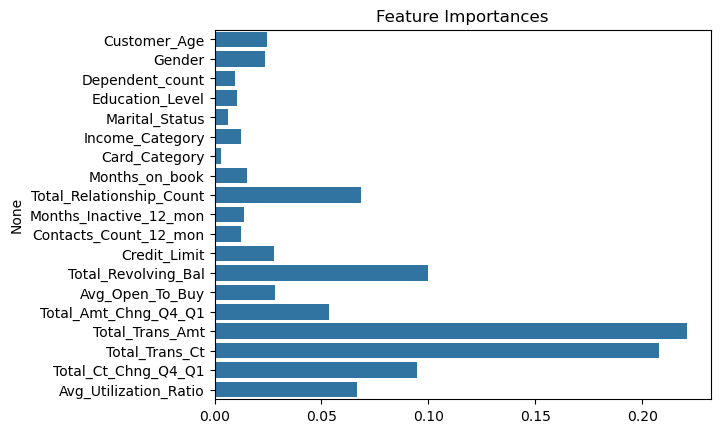

Customer_Age: 0.024440631455518263
Gender: 0.02374021552076733
Dependent_count: 0.009589034639154032
Education_Level: 0.01028989748295751
Marital_Status: 0.006347090526811042
Income_Category: 0.012319956458827814
Card_Category: 0.0030508163062036003
Months_on_book: 0.015161398457488748
Total_Relationship_Count: 0.06865557797925055
Months_Inactive_12_mon: 0.013899994843383437
Contacts_Count_12_mon: 0.012543683773884637
Credit_Limit: 0.027961583687357874
Total_Revolving_Bal: 0.09990549988865767
Avg_Open_To_Buy: 0.02844757890601303
Total_Amt_Chng_Q4_Q1: 0.053631208864256236
Total_Trans_Amt: 0.22091603651233568
Total_Trans_Ct: 0.20788860241852886
Total_Ct_Chng_Q4_Q1: 0.09468077741107246
Avg_Utilization_Ratio: 0.06653041486753129


In [73]:
model = RandomForestClassifier(random_state=42)
model.fit(X_resampled,y_resampled)

importances = model.feature_importances_
features = X_train.columns
import seaborn as sns


sns.barplot(x=importances, y=features)
plt.title("Feature Importances")
plt.show()

for importance, feature in zip(importances, features):
    print(f"{feature}: {importance}")

- Now based on the importances lets try and check if binning a few continous columns improves the importance or not

In [74]:
columns_to_bin = {
    'Total_Trans_Amt': 5,
    'Total_Trans_Ct': 5,
    'Total_Ct_Chng_Q4_Q1': 4,
    'Avg_Utilization_Ratio': 4,
    'Total_Revolving_Bal': 5,
    'Credit_Limit': 4,
    'Customer_Age': 5
}

df_binned = df.copy()

for col, n_bins in columns_to_bin.items():
    bin_col_name = f"{col}_binned"
    df_binned[bin_col_name] = pd.cut(df_binned[col], bins=n_bins, labels=False)
    df_binned.drop(columns=col, inplace=True)

X_binned = df_binned.drop(columns=["Attrition_Flag"])
y_binned = df_binned["Attrition_Flag"]
X_train_binned, X_test_binned, y_train_binned, y_test_binned = tts(X_binned, y_binned, stratify=y_binned, test_size=0.2, random_state=42)
df_binned

,Attrition_Flag,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt_binned,Total_Trans_Ct_binned,Total_Ct_Chng_Q4_Q1_binned,Avg_Utilization_Ratio_binned,Total_Revolving_Bal_binned,Credit_Limit_binned,Customer_Age_binned
0,0,1,3,3,1,2,0,39,5,1,3,11914.0,1.335,0,1,1,0,1,1,2
1,0,0,5,2,2,4,0,44,6,1,2,7392.0,1.541,0,0,3,0,1,0,2
2,0,1,3,2,1,3,0,36,4,1,0,3418.0,2.594,0,0,2,0,0,0,2
3,0,0,4,3,3,4,0,34,3,4,1,796.0,1.405,0,0,2,3,4,0,1
4,0,1,3,5,1,2,0,21,5,1,0,4716.0,2.175,0,0,2,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0,1,2,2,2,1,0,40,3,2,3,2152.0,0.703,4,4,0,1,3,0,2
10123,1,1,2,6,0,1,0,25,4,2,3,2091.0,0.804,2,2,0,2,4,0,1
10124,1,0,1,3,1,4,0,36,5,3,4,5409.0,0.819,2,1,0,0,0,0,1
10125,1,1,2,2,3,1,0,36,4,3,3,5281.0,0.535,2,2,0,0,0,0,0


In [75]:
X_resampled_binned, y_resampled_binned = smote.fit_resample(X_train_binned, y_train_binned)

rf_smote_binned = RandomForestClassifier(random_state=42)

accuracy_scores_smote_binned = cross_val_score(rf_smote_binned, X_resampled_binned, y_resampled_binned, cv=skf, scoring='accuracy')
recall_scores_smote_binned = cross_val_score(rf_smote_binned, X_resampled_binned, y_resampled_binned, cv=skf, scoring='recall')

print("\n=== Random Forest with SMOTE and Manual binning ===")
print("Accuracy:", np.mean(accuracy_scores_smote_binned))
print("Recall:", np.mean(recall_scores_smote_binned))


=== Random Forest with SMOTE and Manual binning ===
Accuracy: 0.948081068948359
Recall: 0.9526403497381294


- Manual binning reduced the performance of Random Forest with smote
- These classifiers—Decision Tree, Random Forest, XGBoost, and CatBoost—automatically determine the most efficient split points for continuous features during training, using techniques like dynamic thresholding or automatic binning. As a result, manual binning is unnecessary, as they are designed to handle raw continuous data effectively.

So we must not do manual binning.

In [76]:
print("\n=== Random Forest with SMOTE ===")
print("Accuracy:", np.mean(accuracy_scores_smote))
print("Recall:", np.mean(recall_scores_smote))

# === XGBoost ===
xgb_smote = XGBClassifier(eval_metric='logloss', random_state=42)
accuracy_scores_xgb = cross_val_score(xgb_smote, X_resampled, y_resampled, cv=skf, scoring='accuracy')
recall_scores_xgb = cross_val_score(xgb_smote, X_resampled, y_resampled, cv=skf, scoring='recall')

print("\n=== XGBoost with SMOTE ===")
print("Accuracy:", np.mean(accuracy_scores_xgb))
print("Recall:", np.mean(recall_scores_xgb))

# === LightGBM ===
lgbm_smote = LGBMClassifier(verbose=-1, random_state=42)
accuracy_scores_lgbm = cross_val_score(lgbm_smote, X_resampled, y_resampled, cv=skf, scoring='accuracy')
recall_scores_lgbm = cross_val_score(lgbm_smote, X_resampled, y_resampled, cv=skf, scoring='recall')

print("\n=== LightGBM with SMOTE ===")
print("Accuracy:", np.mean(accuracy_scores_lgbm))
print("Recall:", np.mean(recall_scores_lgbm))

# === CatBoost ===
catboost_smote = CatBoostClassifier(verbose=0, random_state=42)
accuracy_scores_cat = cross_val_score(catboost_smote, X_resampled, y_resampled, cv=skf, scoring='accuracy')
recall_scores_cat = cross_val_score(catboost_smote, X_resampled, y_resampled, cv=skf, scoring='recall')

print("\n=== CatBoost with SMOTE ===")
print("Accuracy:", np.mean(accuracy_scores_cat))
print("Recall:", np.mean(recall_scores_cat))


=== Random Forest with SMOTE ===
Accuracy: 0.9770588235294116
Recall: 0.9847058823529412

=== XGBoost with SMOTE ===
Accuracy: 0.9816176470588236
Recall: 0.9880882352941176

=== LightGBM with SMOTE ===
Accuracy: 0.9799999999999999
Recall: 0.9863235294117649

=== CatBoost with SMOTE ===
Accuracy: 0.983529411764706
Recall: 0.9888235294117648



===== CatBoost =====
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1700
           1       0.98      0.99      0.98      1700

    accuracy                           0.98      3400
   macro avg       0.98      0.98      0.98      3400
weighted avg       0.98      0.98      0.98      3400

Accuracy: 0.9847
Recall: 0.9888


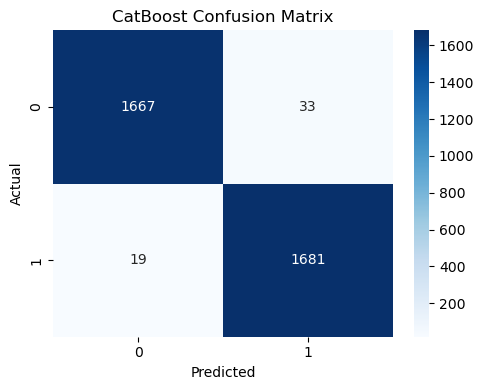

In [79]:
catboost_smote.fit(X_resampled, y_resampled)
print(f"\n===== CatBoost =====")
y_pred = catboost_smote.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
cm1 = cm(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues')
plt.title(f'CatBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [80]:
import joblib
joblib.dump(catboost_smote, 'catboost_smote.pkl')

['catboost_smote.pkl']

###  Final Thoughts

-  **All models performed very well** with both high accuracy and recall, thanks to SMOTE improving minority class representation.
-  **CatBoost** for overall best performance balance.